# 1. Data wrangling and assembly pipeline

> download the data, run the viral genome assembly pipeline and sanity check the assemblies

***

## Overview

### 1. download the data

* viral reference genomes from RefSeq
* 3 Ebola virus (EBOV) MinIon run data
    - multiplexed on one flowcell
    - already basecalled with Guppy (both fast and high accuracy models)
* Nipah virus (NiV) MinIon run data

### 2. run the pipeline

#### pipeline steps

* demux and trim basecalled reads with qcat
    * optional read subsampling with pomoxis
        * subsampled reads are used with all downstream Nanopolish processes
* **method 1**: align, variant call and augment the reference genome
    * assemble with minimap2
    * variant call with either:
        * **method 1.a**: medaka for variant calling
        * **method 1.b**: nanopolish for variant calling
    * augment the reference with each variant set using bcftools
* **method 2**: reference guided assembly
    * assemble with pomoxis (minimap2/miniasm/racon)
* **method 3**: de novo assembly
    * assemble with either miniasm or redbean
    * correct assemblies with racon
    * polish assemblies with either: 
        * **method 3.a**: medaka only
        * **method 3.b**: nanopolish only
        * **method 3.c**: medaka then nanopolish
        * **method 3.d**: nanopolish then medaka
* basic assessment of assemblies
    * quast
    * depth plots

#### pipeline output

The pipeline will produce several files per sample. It will place the files for each method in a sub directory in the specified output directory. This table summarises the method used to reach each:

| filename | method | summary |
| :---- | :---- | :---- |
| reference-alignment/barcode-XX.ref-alignment.medaka.fasta | method 1a | reference alignment > variant call with medaka > augment reference genome |
| reference-alignment/barcode-XX.ref-alignment.nanopolish.fasta | method 1b | reference alignment > variant call with nanopolish > augment reference genome |
| reference-guided-assembly/barcode-XX.rg-assembly.racon.fasta | method 2 | reference guided assembly > correct with racon |
| de-novo-assembly/barcode-XX.dn-assembly.racon.medaka.fasta | method 3a | de novo assembly > correct with racon > polish with medaka |
| de-novo-assembly/barcode-XX.dn-assembly.racon.nanopolish.fasta | method 3b | de novo assembly > correct with racon > polish with nanopolish |
| de-novo-assembly/barcode-XX.dn-assembly.racon.medaka.nanopolish.fasta | method 3c | de novo assembly > correct with racon > polish with medaka > polish with nanopolish |
| de-novo-assembly/barcode-XX.dn-assembly.racon.nanopolish.medaka.fasta | method 3d | de novo assembly > correct with racon > polish with nanopolish > polish with medaka |


### 3. assess the assemblies

* quick assessment of all the assemblies against the current viral genomes in RefSeq
* **note**: I've restricted this to just ebola for now, but can make this more generic later

***

## TODO

### pipelines: 
1. add in subsampling variations for pomoxis
2. add in some qcat parameters (e.g. read length, Q score), and summarise qcat output

### analysis:
1. run Nipah data from ARTIC release
2. run the synthetic genome
3. try with amplocon data - may not assemble
    * try using the align trim script of Nick's (which soft masks the bam)
    * add in checks for run-through chimeras (check double barcodes)

***


## Download the data

Download the complete ebola assemblies from RefSeq:

In [1]:
!ncbi-genome-download --format fasta --assembly-level complete --fuzzy-genus --genus ebola viral -o tmp --parallel 8 --retries 2

Download the Ebola virus Nanopore run data from the [artic data releases](http://artic.network/protocol_validation_2019.html):

* we are using the Ebola virus (EBOV) minion run that sequenced 3 strains of the virus (Mayinga, Kikwit, Makona) using the metagenomic protocol with rapid PCR kit

In [1]:
!wget -q --directory-prefix=tmp/ http://artic.s3.climb.ac.uk/run-folders/EBOV_Metagenomics.tar.gz 
!tar -xf tmp/EBOV_Metagenomics.tar.gz -C tmp/ --strip-components=1

  HTTP/1.1 200 OK
  Server: nginx/1.14.0
  Date: Wed, 23 Oct 2019 11:05:39 GMT
  Content-Type: application/gzip
  Content-Length: 1070346070
  Connection: keep-alive
  Accept-Ranges: bytes
  Last-Modified: Tue, 03 Sep 2019 15:29:47 GMT
  ETag: "6e2449545dc6d1ac030505b880132e29-8"
  x-amz-meta-s3cmd-attrs: atime:1567522299/ctime:1567522360/gid:1000/gname:artic/md5:eb30cd588722793c39455ceb97898874/mode:33188/mtime:1567522310/uid:1000/uname:artic
  x-amz-request-id: tx000000000000000020a5c-005db03403-358ae6ba-s3-warwick


## Long read assembly pipeline

The library that we just downloaded contains 3 barcoded samples - we want barcodes 9, 10 and 11 (9=Mayinga,10=Kikwit,11=Makona)

This library was already basecalled with Guppy, both using the fast and high accuracy (hac) models. These are already in the current repository:

>./pipelines/data/ebov-metagenomics-reads

The nextflow pipeline will perform reference alignment and variant calling, as well as both de-novo and reference guided assemblies.

* **note**: this takes around 20 minutes using the settings below
* **note**: make sure you have docker installed and the daemon is running!

First, we need to provide a reference genome for each of the barcodes. This is done via a multifasta where each fasta header contains the barcode. The reference genomes are already available in the repo:

>./pipelines/data/ebov-reference-genomes


So that the pipeline gets the right reference genome for each sample, the multifasta headers must be prefixed with a lookup in the form: `barcode-XX---`. The barcodes and corresponding reference genomes are:

|barcode|strain|reference|
|-------|------|---------|
|09     |mayinga|NC_002549.fasta|
|10     |kikwit|JQ352763.fasta|
|11     |makona|KR781608.fasta|

Make the reference genome multifasta:

In [2]:
!sed 's/>/>barcode-09---/' $PWD/pipelines/data/ebov-reference-genomes/NC_002549.fasta >> tmp/refGenomes.fasta
!sed 's/>/>barcode-10---/' $PWD/pipelines/data/ebov-reference-genomes/JQ352763.fasta >> tmp/refGenomes.fasta
!sed 's/>/>barcode-11---/' $PWD/pipelines/data/ebov-reference-genomes/KR781608.fasta >> tmp/refGenomes.fasta

Now we can run the pipeline:

In [4]:
!nextflow run pipelines/long-read-assembly.nf \
    -profile docker \
    --cpus 8 \
    --mem 14GB \
    --fastqDir $PWD/pipelines/data/ebov-metagenomics-reads/guppy-r941-fast \
    --fast5Dir $PWD/tmp/fast5_pass \
    --barcodes 09,10,11 \
    --refGenomes $PWD/tmp/refGenomes.fasta \
    --output pipelines/data/pipeline-results/r941_min_fast \
    --assembler miniasm \
    --subSamplingDepth 100 \
    --label fast \
    -resume

N E X T F L O W  ~  version 19.07.0
Launching `pipelines/long-read-assembly.nf` [sad_jennings] - revision: f7c28d6b4e
-------------------------------------------------------
long read assembly pipeline v0.1
-------------------------------------------------------
Directory with fastq: /Users/willrowe/Desktop/signal-check/pipelines/data/ebov-metagenomics-reads/guppy-r941-fast
Directory with fast5: /Users/willrowe/Desktop/signal-check/tmp/fast5_pass
Reference genomes: /Users/willrowe/Desktop/signal-check/tmp/refGenomes.fasta
File prepend label: fast
Barcodes       : 09,10,11
Sequencing kit : Auto
Sampling depth : 100
Racon iterat.  : 4
Medaka model   : r941_min_fast
Output dir     : pipelines/data/pipeline-results/r941_min_fast
Working dir    : /Users/willrowe/Desktop/signal-check/work
Max. memory    : 14GB
Max. CPUs      : 8
Profile        : docker
Current home   : /Users/willrowe
Current user   : willrowe
Current path   : /Users/willrowe/Desktop/signal-check
Script dir     : /Users/will


executor >  local (8)
[b6/c84104] process > demuxingReads                  [100%] 1 of 1, cached: 1 ✔
[80/c85768] process > referenceAlignment (2)         [100%] 3 of 3, cached: 3 ✔
[5f/77975c] process > subsamplingReads (2)           [100%] 3 of 3 ✔
[-        ] process > nanopolishIndexing             -
[-        ] process > variantcallWithMedaka          -
[-        ] process > variantcallWithNanopolish      -
[f4/3f473e] process > assemblingReadsRG (3)          [100%] 3 of 3 ✔
[57/6bf292] process > assemblingReadsDN (3)          [100%] 3 of 3, cached: 3 ✔
[97/3d3385] process > correctingAssemblyWithRacon... [ 50%] 1 of 2
[-        ] process > polishingWithMedakaDN          -
[-        ] process > repolishingWithNanopolishDN    -
[-        ] process > polishingWithNanopolishDN      -
[-        ] process > repolishingWithMedakaDN        -
[-        ] process > assessAssemblies               -

executor >  local (9)
[b6/c84104] process > demuxingReads                  [100%] 1 of 1, c


executor >  local (17)
[b6/c84104] process > demuxingReads                  [100%] 1 of 1, cached: 1 ✔
[80/c85768] process > referenceAlignment (2)         [100%] 3 of 3, cached: 3 ✔
[5f/77975c] process > subsamplingReads (2)           [100%] 3 of 3 ✔
[b2/a62998] process > nanopolishIndexing (3)         [100%] 3 of 3 ✔
[49/dbb725] process > variantcallWithMedaka (1)      [100%] 3 of 3 ✔
[-        ] process > variantcallWithNanopolish      -
[f4/3f473e] process > assemblingReadsRG (3)          [100%] 3 of 3 ✔
[57/6bf292] process > assemblingReadsDN (3)          [100%] 3 of 3, cached: 3 ✔
[55/12aa4f] process > correctingAssemblyWithRacon... [100%] 3 of 3 ✔
[43/5fab42] process > polishingWithMedakaDN (2)      [ 50%] 1 of 2
[-        ] process > repolishingWithNanopolishDN    -
[-        ] process > polishingWithNanopolishDN      -
[-        ] process > repolishingWithMedakaDN        -
[-        ] process > assessAssemblies               -

executor >  local (18)
[b6/c84104] process > dem


executor >  local (26)
[b6/c84104] process > demuxingReads                  [100%] 1 of 1, cached: 1 ✔
[80/c85768] process > referenceAlignment (2)         [100%] 3 of 3, cached: 3 ✔
[5f/77975c] process > subsamplingReads (2)           [100%] 3 of 3 ✔
[b2/a62998] process > nanopolishIndexing (3)         [100%] 3 of 3 ✔
[49/dbb725] process > variantcallWithMedaka (1)      [100%] 3 of 3 ✔
[96/326fdf] process > variantcallWithNanopolish (3)  [100%] 3 of 3 ✔
[f4/3f473e] process > assemblingReadsRG (3)          [100%] 3 of 3 ✔
[57/6bf292] process > assemblingReadsDN (3)          [100%] 3 of 3, cached: 3 ✔
[55/12aa4f] process > correctingAssemblyWithRacon... [100%] 3 of 3 ✔
[cc/609019] process > polishingWithMedakaDN (3)      [100%] 3 of 3 ✔
[40/718b73] process > repolishingWithNanopolishDN... [ 50%] 1 of 2
[2b/f1a82a] process > polishingWithNanopolishDN (3)  [100%] 3 of 3 ✔
[-        ] process > repolishingWithMedakaDN        -
[-        ] process > assessAssemblies               -

execut


executor >  local (33)
[b6/c84104] process > demuxingReads                  [100%] 1 of 1, cached: 1 ✔
[80/c85768] process > referenceAlignment (2)         [100%] 3 of 3, cached: 3 ✔
[5f/77975c] process > subsamplingReads (2)           [100%] 3 of 3 ✔
[b2/a62998] process > nanopolishIndexing (3)         [100%] 3 of 3 ✔
[49/dbb725] process > variantcallWithMedaka (1)      [100%] 3 of 3 ✔
[96/326fdf] process > variantcallWithNanopolish (3)  [100%] 3 of 3 ✔
[f4/3f473e] process > assemblingReadsRG (3)          [100%] 3 of 3 ✔
[57/6bf292] process > assemblingReadsDN (3)          [100%] 3 of 3, cached: 3 ✔
[55/12aa4f] process > correctingAssemblyWithRacon... [100%] 3 of 3 ✔
[cc/609019] process > polishingWithMedakaDN (3)      [100%] 3 of 3 ✔
[7a/63c43c] process > repolishingWithNanopolishDN... [100%] 3 of 3 ✔
[2b/f1a82a] process > polishingWithNanopolishDN (3)  [100%] 3 of 3 ✔
[18/d1e294] process > repolishingWithMedakaDN (3)    [100%] 3 of 3 ✔
[c4/0e202b] process > assessAssemblies (3)    

Run the pipeline again, this time using the high accuracy basecalled data:

* **note**: we change the medaka model and the pipeline run label

In [11]:
!nextflow run pipelines/long-read-assembly.nf \
    -profile docker \
    --cpus 8 \
    --mem 14GB \
    --fastqDir $PWD/pipelines/data/ebov-metagenomics-reads/guppy-r941-hac \
    --fast5Dir $PWD/tmp/fast5_pass \
    --barcodes 09,10,11 \
    --refGenomes $PWD/tmp/refGenomes.fasta \
    --output pipelines/data/pipeline-results/r941_min_hac \
    --assembler miniasm \
    --subSamplingDepth 100 \
    --medakaModel r941_min_high \
    --label hac \
    -resume

N E X T F L O W  ~  version 19.07.0
Launching `pipelines/long-read-assembly.nf` [peaceful_visvesvaraya] - revision: f7c28d6b4e
-------------------------------------------------------
long read assembly pipeline v0.1
-------------------------------------------------------
Directory with fastq: /Users/willrowe/Desktop/signal-check/pipelines/data/ebov-metagenomics-reads/guppy-r941-hac
Directory with fast5: /Users/willrowe/Desktop/signal-check/tmp/fast5_pass
Reference genomes: /Users/willrowe/Desktop/signal-check/tmp/refGenomes.fasta
File prepend label: hac
Barcodes       : 09,10,11
Sequencing kit : Auto
Sampling depth : 100
Racon iterat.  : 4
Medaka model   : r941_min_high
Output dir     : pipelines/data/pipeline-results/r941_min_hac
Working dir    : /Users/willrowe/Desktop/signal-check/work
Max. memory    : 14GB
Max. CPUs      : 8
Profile        : docker
Current home   : /Users/willrowe
Current user   : willrowe
Current path   : /Users/willrowe/Desktop/signal-check
Script dir     : /User


executor >  local (6)
[29/efecbf] process > demuxingReads                  [100%] 1 of 1, cached: 1 ✔
[04/3502ca] process > referenceAlignment (3)         [100%] 3 of 3, cached: 3 ✔
[41/4b05cb] process > subsamplingReads (3)           [100%] 3 of 3, cached: 3 ✔
[5f/d6e172] process > nanopolishIndexing (2)         [100%] 3 of 3, cached: 3 ✔
[b1/54be39] process > variantcallWithMedaka (3)      [100%] 3 of 3, cached: 3 ✔
[5f/2ba0e3] process > variantcallWithNanopolish (3)  [ 67%] 2 of 3, cached: 1
[4b/48da60] process > assemblingReadsRG (1)          [100%] 3 of 3, cached: 3 ✔
[70/37aa1f] process > assemblingReadsDN (3)          [100%] 3 of 3, cached: 3 ✔
[13/a3dfd0] process > correctingAssemblyWithRacon... [100%] 3 of 3, cached: 3 ✔
[b7/28d3c7] process > polishingWithMedakaDN (3)      [100%] 3 of 3, cached: 3 ✔
[6f/278714] process > repolishingWithNanopolishDN... [100%] 1 of 1
[5a/1c78c1] process > polishingWithNanopolishDN (3)  [100%] 3 of 3 ✔
[-        ] process > repolishingWithMedaka


executor >  local (14)
[29/efecbf] process > demuxingReads                  [100%] 1 of 1, cached: 1 ✔
[04/3502ca] process > referenceAlignment (3)         [100%] 3 of 3, cached: 3 ✔
[41/4b05cb] process > subsamplingReads (3)           [100%] 3 of 3, cached: 3 ✔
[5f/d6e172] process > nanopolishIndexing (2)         [100%] 3 of 3, cached: 3 ✔
[b1/54be39] process > variantcallWithMedaka (3)      [100%] 3 of 3, cached: 3 ✔
[5f/2ba0e3] process > variantcallWithNanopolish (3)  [100%] 3 of 3, cached: 1 ✔
[4b/48da60] process > assemblingReadsRG (1)          [100%] 3 of 3, cached: 3 ✔
[70/37aa1f] process > assemblingReadsDN (3)          [100%] 3 of 3, cached: 3 ✔
[13/a3dfd0] process > correctingAssemblyWithRacon... [100%] 3 of 3, cached: 3 ✔
[b7/28d3c7] process > polishingWithMedakaDN (3)      [100%] 3 of 3, cached: 3 ✔
[eb/e3d8b7] process > repolishingWithNanopolishDN... [100%] 3 of 3 ✔
[5a/1c78c1] process > polishingWithNanopolishDN (3)  [100%] 3 of 3 ✔
[ca/a2226d] process > repolishingWithM

## Quick assessment of the assemblies

As a sanity check, check the assemblies from each of the above pipelines against the viral RefSeq genomes:

In [12]:
# get a file list of all the viral genomes we downloaded from refseq
!find $PWD/tmp/refseq/viral/GCF_00*/*.gz > tmp/ref-genomes.list

# add in the ebola references we have already used
!find $PWD/pipelines/data/ebov-reference-genomes/*.fasta >> tmp/ref-genomes.list

# get a file list of all the assemblies we just made
!find $PWD/pipelines/data/pipeline-results/r941_min_*/*-assembly/*.dn-assembly.*.fasta > tmp/dn-assembled-genomes.list
!find $PWD/pipelines/data/pipeline-results/r941_min_*/*-assembly/*.rg-assembly.*.fasta > tmp/rg-assembled-genomes.list

# run fastani to compute Average Nucleotide Identity
!fastani --rl tmp/ref-genomes.list --ql tmp/dn-assembled-genomes.list -o tmp/dn-assemblies-fastani.tab --fragLen 100 --matrix
!fastani --rl tmp/ref-genomes.list --ql tmp/rg-assembled-genomes.list -o tmp/rg-assemblies-fastani.tab --fragLen 100 --matrix

>>>>>>>>>>>>>>>>>>
Reference = [/Users/willrowe/Desktop/signal-check/tmp/refseq/viral/GCF_000848505.1/GCF_000848505.1_ViralProj14703_genomic.fna.gz, /Users/willrowe/Desktop/signal-check/tmp/refseq/viral/GCF_000854085.1/GCF_000854085.1_ViralProj15006_genomic.fna.gz, /Users/willrowe/Desktop/signal-check/tmp/refseq/viral/GCF_000855585.1/GCF_000855585.1_ViralProj15012_genomic.fna.gz, /Users/willrowe/Desktop/signal-check/tmp/refseq/viral/GCF_000888475.1/GCF_000888475.1_ViralProj51257_genomic.fna.gz, /Users/willrowe/Desktop/signal-check/tmp/refseq/viral/GCF_000889155.1/GCF_000889155.1_ViralProj51245_genomic.fna.gz, /Users/willrowe/Desktop/signal-check/tmp/refseq/viral/GCF_003505815.1/GCF_003505815.1_ASM350581v1_genomic.fna.gz, /Users/willrowe/Desktop/signal-check/pipelines/data/ebov-reference-genomes/JQ352763.fasta, /Users/willrowe/Desktop/signal-check/pipelines/data/ebov-reference-genomes/KR781608.fasta, /Users/willrowe/Desktop/signal-check/pipelines/data/ebov-reference-genomes/NC_002549.fa

INFO [thread 0], skch::main, Time spent mapping fragments in query #14 : 0.0558471 sec
INFO [thread 0], skch::main, Time spent post mapping : 6.9416e-05 sec
INFO [thread 0], skch::main, Time spent mapping fragments in query #15 : 0.0553834 sec
INFO [thread 0], skch::main, Time spent post mapping : 7.7166e-05 sec
INFO [thread 0], skch::main, Time spent mapping fragments in query #16 : 0.0580356 sec
INFO [thread 0], skch::main, Time spent post mapping : 5.9629e-05 sec
INFO [thread 0], skch::main, Time spent mapping fragments in query #17 : 0.0574402 sec
INFO [thread 0], skch::main, Time spent post mapping : 6.228e-05 sec
INFO [thread 0], skch::main, Time spent mapping fragments in query #18 : 0.0580266 sec
INFO [thread 0], skch::main, Time spent post mapping : 5.9175e-05 sec
INFO [thread 0], skch::main, Time spent mapping fragments in query #19 : 0.0585328 sec
INFO [thread 0], skch::main, Time spent post mapping : 6.6124e-05 sec
INFO [thread 0], skch::main, Time spent mapping fragments i

In [13]:
# plot the pairwise ANI scores as a heatmap
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
sequential_colors = sns.color_palette("RdPu", 10)

# convert triangular matrix to a regular one (https://github.com/marbl/Mash/issues/9#issuecomment-509837201)
def lower_triangle_to_full_matrix(filename):
    num_lines_in_file = sum(1 for line in open(filename))
    distances = []
    sample_names = []

    with open(filename) as f:
        next(f) # skip sample count line
        for line in f:
            elements = line.strip().split('\t')
            for i, e in enumerate(elements):
                if e == 'NA':
                    elements[i] = 0.0
            elements[0] = os.path.basename(elements[0])
            sample_names.append(elements[0])
            row = [float(e) for e in elements[1:]]
            row.extend([0.0] * (num_lines_in_file-1-len(row)))
            distances.append(row)
        np_array = np.asarray(distances)
        index_upper = np.triu_indices(num_lines_in_file-1)
        np_array[index_upper] = np_array.T[index_upper]
        return pd.DataFrame(np_array, columns=sample_names, index=sample_names)

dnAssemblies = lower_triangle_to_full_matrix('tmp/dn-assemblies-fastani.tab.matrix')
rgAssemblies = lower_triangle_to_full_matrix('tmp/rg-assemblies-fastani.tab.matrix')

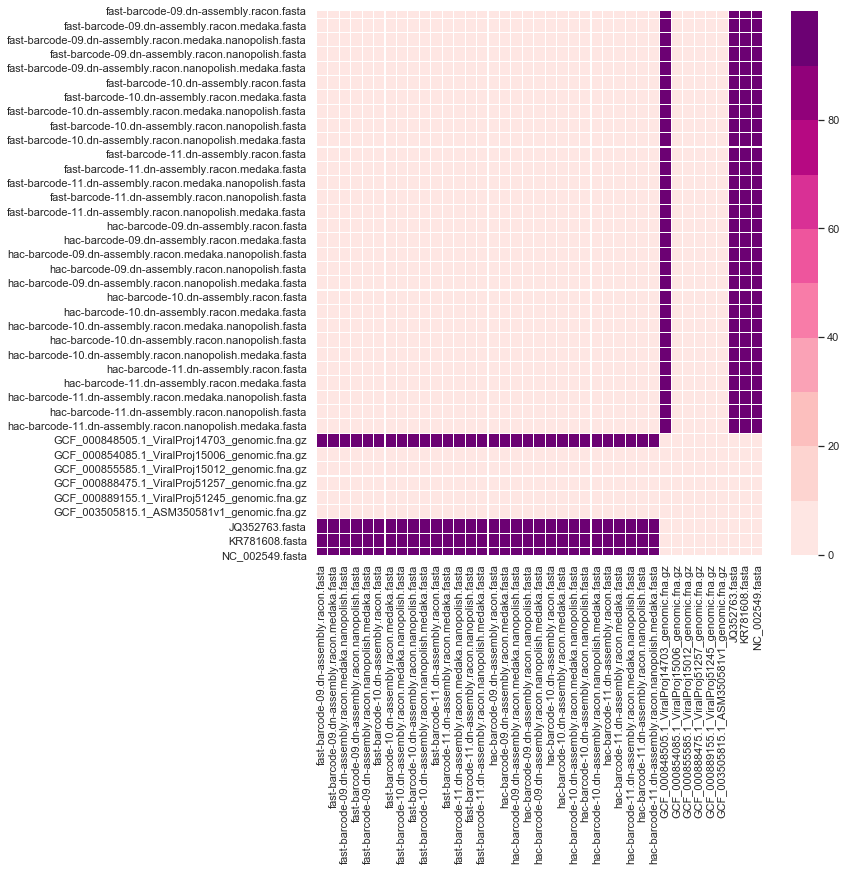

In [14]:
# make the plot for the de novo assemblies (both fast and hac data)
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(dnAssemblies, linewidths=.1, cmap=sequential_colors)

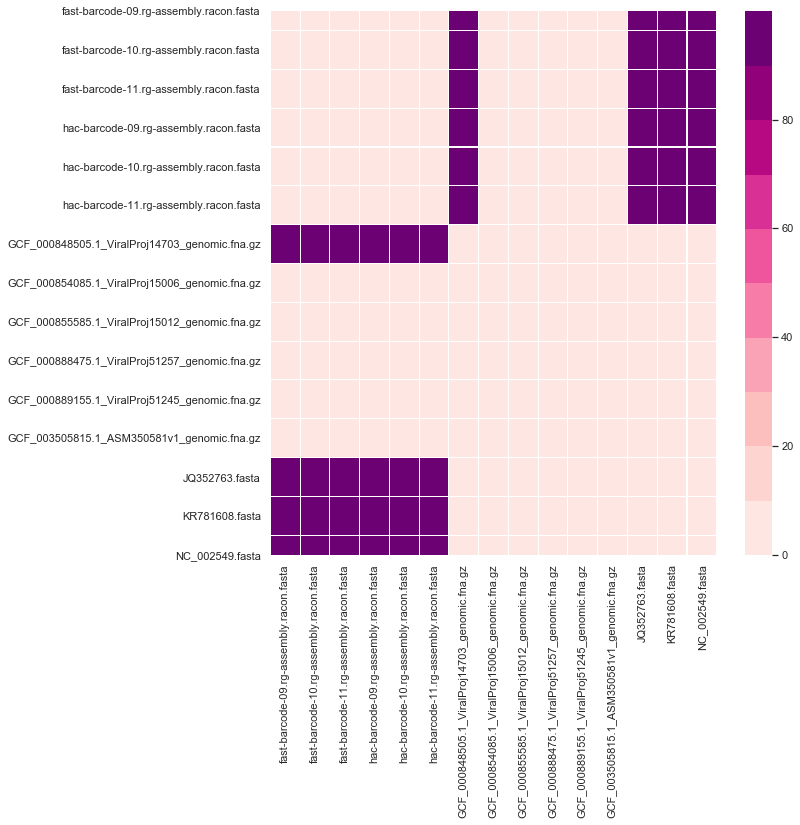

In [15]:
# make the plot for the reference guided assemblies (both fast and hac data)
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(rgAssemblies, linewidths=.1, cmap=sequential_colors)

## Cleanup after running the pipeline

To free up space, move all the intermediary files. Make sure the `tmp` dir is kept as we use the contents in the next workbooks.

In [9]:
!rm -r work/
!rm -r .nextflow*

Move onto the [next workbook](2.evaluating-mayinga-assemblies.ipynb)